In [1]:
from transformers import GPT2Tokenizer

### Data
We want sequence that are long enough where there is room to forget token kvs with minimal information loss.

In [2]:
from tqdm.auto import tqdm
from datasets import load_dataset
import numpy as  np

In [3]:
dataset = load_dataset('wikitext', 'wikitext-103-v1')
split = dataset['train']

In [ ]:
# compute text with token length >= 512
batch = 500
min_tok_length = 512
filtered = []
lengths = []
max_length = 0
for i in tqdm(range(0, len(split), batch)):
    lengths += [len(tok) for tok in tokenizer.batch_encode_plus([split[min(i+j, len(split) - 1)]['text'] for j in range(batch)])['input_ids']]

In [34]:
np.save('token_length.npy', np.array(lengths))

In [4]:
l = np.load('token_length.npy')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
all([len(tok) > 512 for tok in tokenizer.batch_encode_plus([split[int(i)]['text'] for i in np.where(l > 512)[0][:20]])['input_ids']])

True

Text(0.5, 1.0, 'num sequences with L > x')

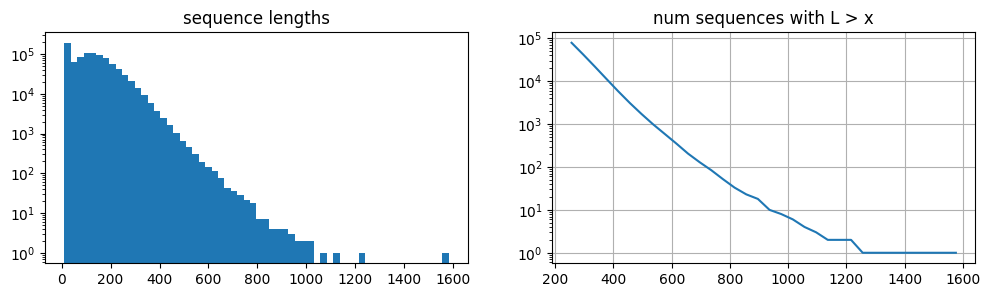

In [30]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(l[l > 10], bins=60)
ax[0].set_yscale('log')
ax[0].set_title('sequence lengths')

tot = []
step = 40
r = range(256, l.max(), step)
ax[1].plot(r, [(l>i).sum() for i in r])
ax[1].grid()
ax[1].set_yscale('log')
ax[1].set_title('num sequences with L > x')

In [29]:
(l > 400).sum()

7626

### Analyis
Study sensitivity in relation to ratio of forgotten kvs as well as timestep of pruning start.

Test pruning (no-FT) based on:
- similarity of k
- similarity of v
- min(sim_k, sim_v)
- cumulative attention weights
- Mix of above

Visualize ppl by number of tokens pruned, both with and without intermediate renormalization


### Apply to MHA (GPT2 WikiText)

In [5]:
import torch
import torch.nn as nn
import numpy as np
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [14]:
DEVICE = 0
PRUNE_RANGE = 0, 200
LOSS_RANGE = 200, 400
DO_PRUNE = False
PRUNE_K = 50  # effectively the number of tokens we prune + 1
PLOTS = None

L = LOSS_RANGE[1]
L_p_ = PRUNE_RANGE[1] - PRUNE_RANGE[0]
n_heads_ = 12
d_ = 64

# define mask and index tensors
ksim_mask_ = torch.tril(torch.ones((L_p_, L_p_), device=DEVICE), diagonal=0).type(torch.bool)  # [ L_p X L_p ]
Lp2_reverse_idx_ = torch.arange(L_p_, device=DEVICE)[None].repeat(L_p_, dim=0)
Lp2_reverse_idx_ = torch.stack([Lp2_reverse_idx_, Lp2_reverse_idx_.T)  # [ L_p X L_p X 2 ]
Lp2_reverse_idx_ = Lp2_reverse_idx_[k_sim_mask_]  # [ L_p^2 X 2 ] => 0: idx in L_p of k_0, 1: idx in L_p of k_1 for matching pair (k_0, k_1)


def compute_topk(ksim):
    """Shapes:
    key_sim:   torch.Size([batch, n heads, L_p, L_p])
    """
    batch_range = torch.arange(ksim.size(0)).to(DEVICE)
    # put into [ batch X n heads X L_p^2 ] for top-k computation
    ksim_flat = ksim.view(-1, n_heads_, L_p_ ** 2)

    # compute top-k similar keys across tokens in prune span per attention head
    topk_indices = ksim_flat.topk(PRUNE_K, dim=-1).indices
    # translate torch.topk().indices return into np.where() return format
    batch_idx = batch_range.repeat_interleave(n_heads_).repeat_interleave(PRUNE_K)  # [ batch * n heads * prune k ]
    attn_head_idx = batch_range.repeat(n_heads_).repeat_interleave(PRUNE_K)         # [ batch * n heads * prune k ]
    Lp2_idx = topk_indices.flatten()                                                # [ batch * n heads * prune k ]

    # put indices back into [ batch X n heads X L_p X L_p ]
    og_idx = Lp2_reverse_idx_[Lp2_idx]  # [ batch * n heads * prune k X 2 ]
    
    return batch_idx, attn_head_idx, *og_idx.T


def compute_ksim(key):
    ksim = torch.matmul(key, key.transpose(-1, -2))  # [ batch X n heads X L_p X L_p ]
    ksim[:,:,ksim_mask_] = float('-inf')
    return ksim


def compute_asim(key):
    pass


def prune(module, query, key, value, attention_mask=None, head_mask=None):
    """Shapes:
    query:          torch.Size([batch, n heads, L, d])
    key:            torch.Size([batch, n heads, L, d])
    value:          torch.Size([batch, n heads, L, d])
    attention_mask: torch.Size([batch, 1, 1, L])
    """

    # compute key similarities
    if PLOTS or DO_PRUNE:
        pruneable_keys = key[:,:,PRUNE_RANGE[0]:PRUNE_RANGE[1]]
        ksim = compute_ksim(pruneable_keys)  # [ batch X n heads X L_p X L_p ]

        if PLOTS:
            ksim_flat_out = ksim[:,:,ksim_mask_].clone().cpu()  # data collection

            # plot histogram

        if DO_PRUNE:
            where_topk = compute_topk(ksim)
            
            # greedy sampling, make sure to leave one token for each k-equivalency class
        
    
    return query, key, value


# modified _attn https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py#L182
def drop_in_attn(self, query, key, value, attention_mask=None, head_mask=None):

    #########################
    # prune before attention

    query, key, value = prune(self, query, key, value, attention_mask, head_mask)
    
    #########################
    
    attn_weights = torch.matmul(query, key.transpose(-1, -2))

    if self.scale_attn_weights:
        attn_weights = attn_weights / torch.full(
            [], value.size(-1) ** 0.5, dtype=attn_weights.dtype, device=attn_weights.device
        )

    # Layer-wise attention scaling
    if self.scale_attn_by_inverse_layer_idx:
        attn_weights = attn_weights / float(self.layer_idx + 1)

    if not self.is_cross_attention:
        # if only "normal" attention layer implements causal mask
        query_length, key_length = query.size(-2), key.size(-2)
        causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length]
        mask_value = torch.finfo(attn_weights.dtype).min
        # Need to be a tensor, otherwise we get error: `RuntimeError: expected scalar type float but found double`.
        # Need to be on the same device, otherwise `RuntimeError: ..., x and y to be on the same device`
        mask_value = torch.full([], mask_value, dtype=attn_weights.dtype).to(attn_weights.device)
        attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)

    if attention_mask is not None:
        # Apply the attention mask
        attn_weights = attn_weights + attention_mask

    attn_weights = nn.functional.softmax(attn_weights, dim=-1)

    # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
    attn_weights = attn_weights.type(value.dtype)
    attn_weights = self.attn_dropout(attn_weights)

    # Mask heads if we want to
    if head_mask is not None:
        attn_weights = attn_weights * head_mask

    attn_output = torch.matmul(attn_weights, value)

    return attn_output, attn_weights

GPT2Attention._attn = drop_in_attn

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(DEVICE)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [12]:
batch_size = 1
no_loss_label = -100  # used to make CE loss ignore this element
indices, = np.where(l > LOSS_RANGE[1])
nlls = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(np.array_split(indices, len(indices) // batch_size))):
        model_input = {name: t.to(DEVICE) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                     return_tensors="pt",
                                                                                     truncation=True,
                                                                                     max_length=LOSS_RANGE[1]).items()}
        labels = model_input['input_ids'].clone()
        labels[:,:LOSS_RANGE[0]] = no_loss_label
        labels[:,LOSS_RANGE[1]:] = no_loss_label
        out = model(**model_input, labels=labels)  # forward pass handles predicted token time shift
        nlls += [out.loss]
ppl = torch.exp(torch.stack(nlls).mean())

  0%|          | 0/7626 [00:00<?, ?it/s]

In [9]:
ppl  # published result is 37.50

tensor(37.0557, device='cuda:0')

In [13]:
ppl  # computed over LOSS_RANGE (lower since tokens we compute loss for now have more prior information)

tensor(29.7449, device='cuda:0')

### Apply to MQA (GPTBigCode)